# 합성곱 신경망 학습 시각화

1. 중간층의 출력을 시각화
 * 연속된 합성곱 층이 입력을 어떻게 변형시키는지 이해하고 개별적인 합성곱 필터의 의미를 파악


2. 필터를 시각화
 * 합성곱 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 이해


3. 클래스 활성화에 대한 히트맵 이미지를 시각화
 * 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체 위치를 추정하는데 도움이 됨

In [9]:
# 1. 중간층의 출력을 시각화

from tensorflow.keras.models import load_model

model = load_model("cats_and_dogs_small_2.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

(1, 150, 150, 3)


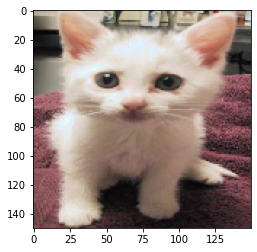

In [10]:
# Image Preprocessing

img_path = "datasets/cats_and_dogs_small/test/cats/cat.3072.jpg"

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)  # Convert to 4D tensor 
img_tensor /= 255.  # normalization

print(img_tensor.shape)


import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [11]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]  # top 8 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# 하나의 입력과 활성화마다 하나씩 총 8개의 출력을 가진 모델

In [21]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


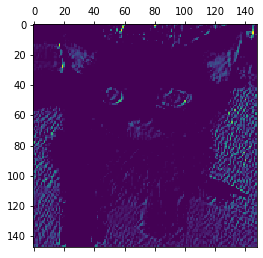

In [40]:
# 임의의 층 시각화
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

<ipython-input-45-99b359d9768d>:24: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
<ipython-input-45-99b359d9768d>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(scale * display_grid.shape[1],


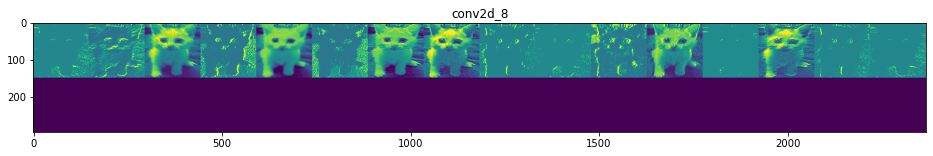

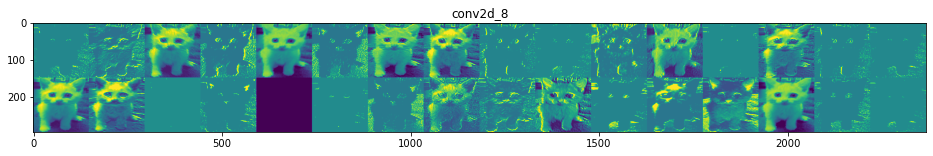

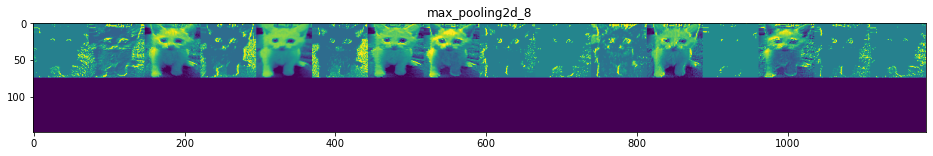

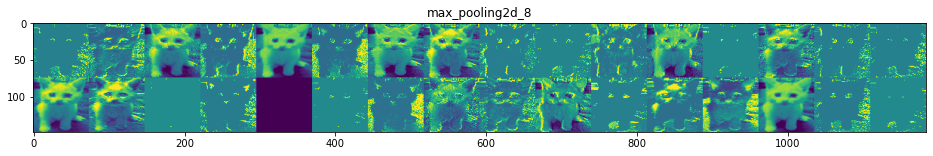

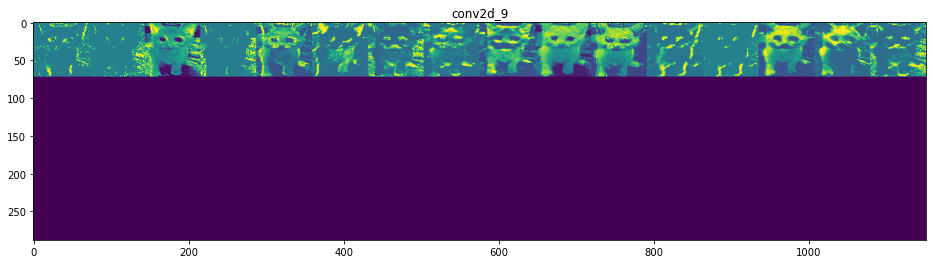

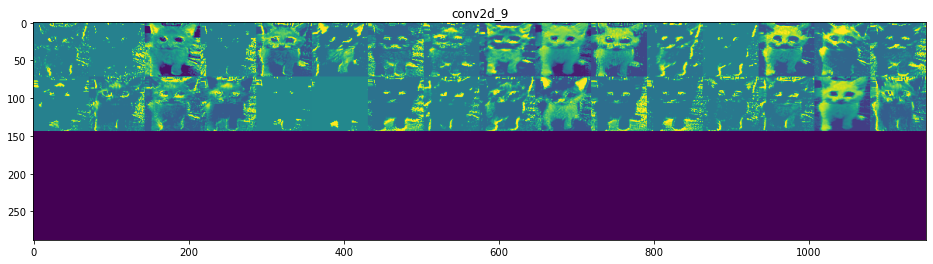

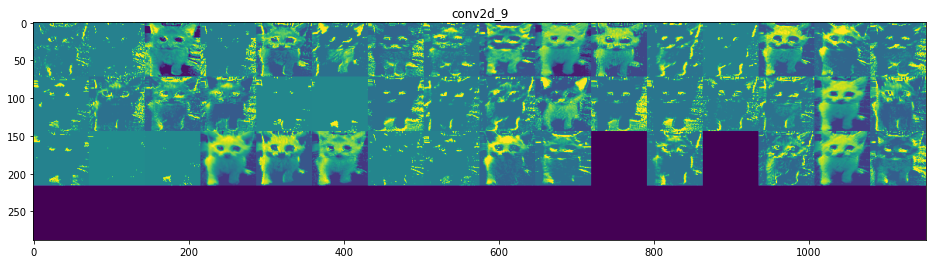

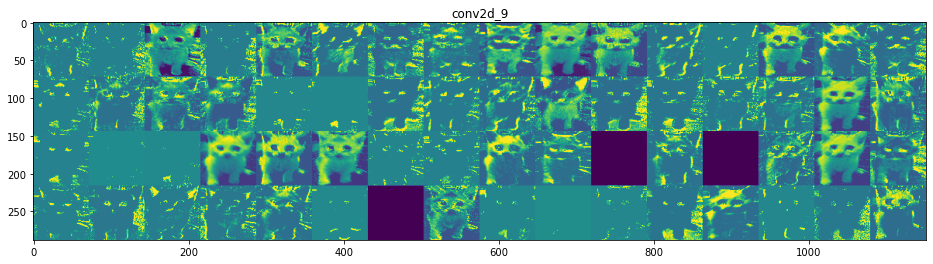

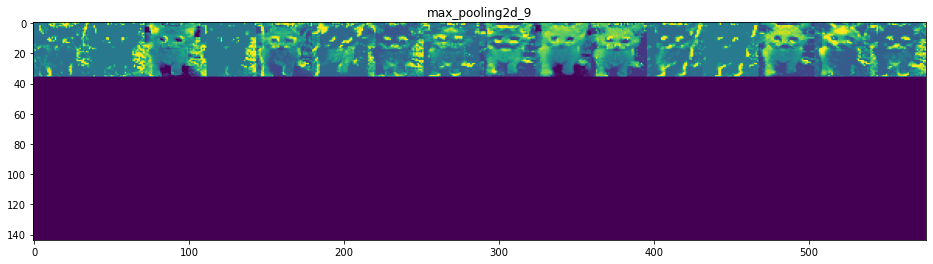

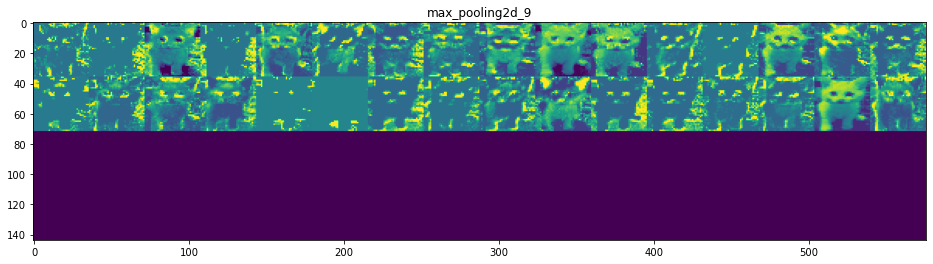

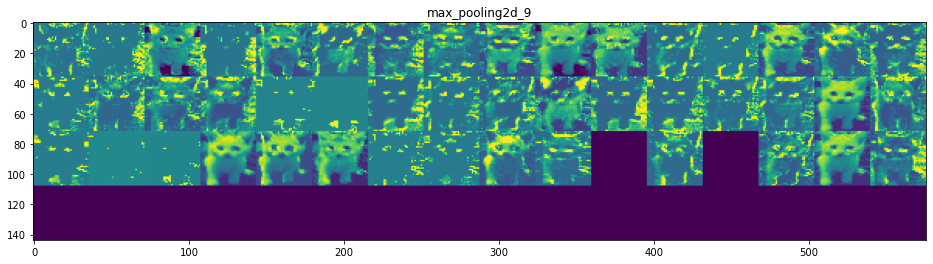

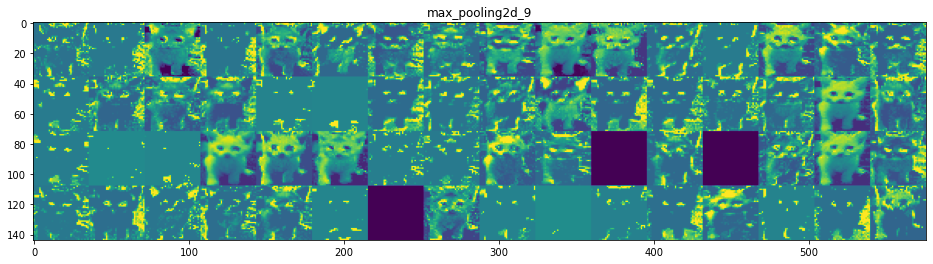

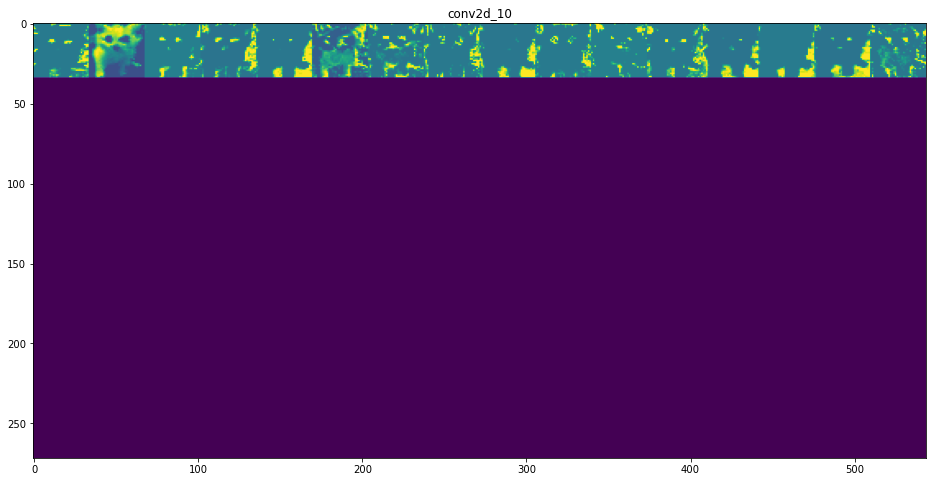

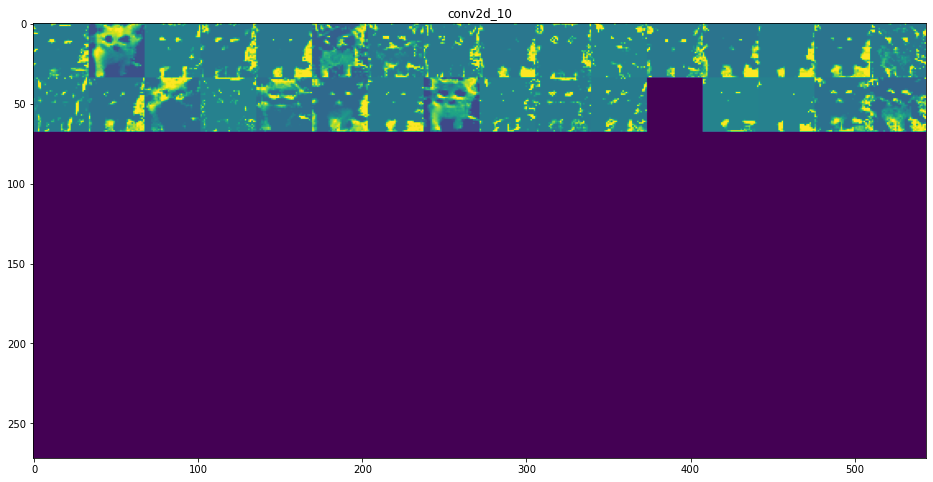

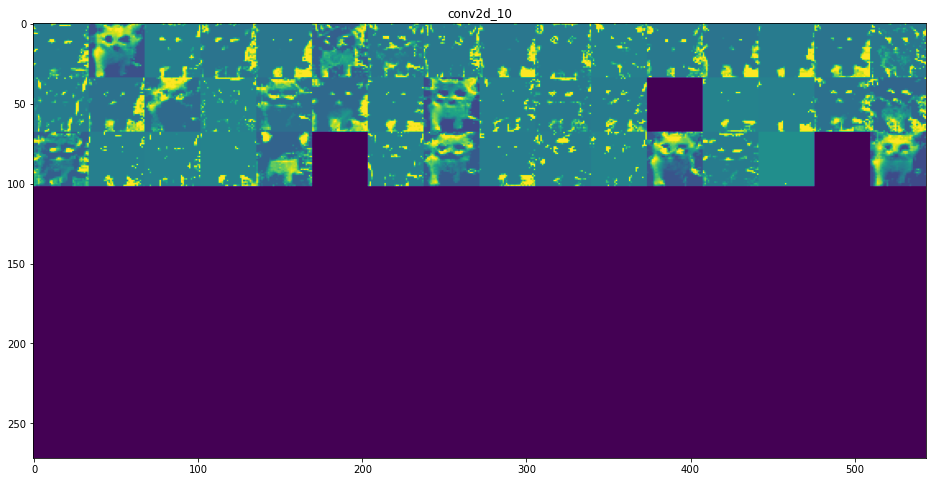

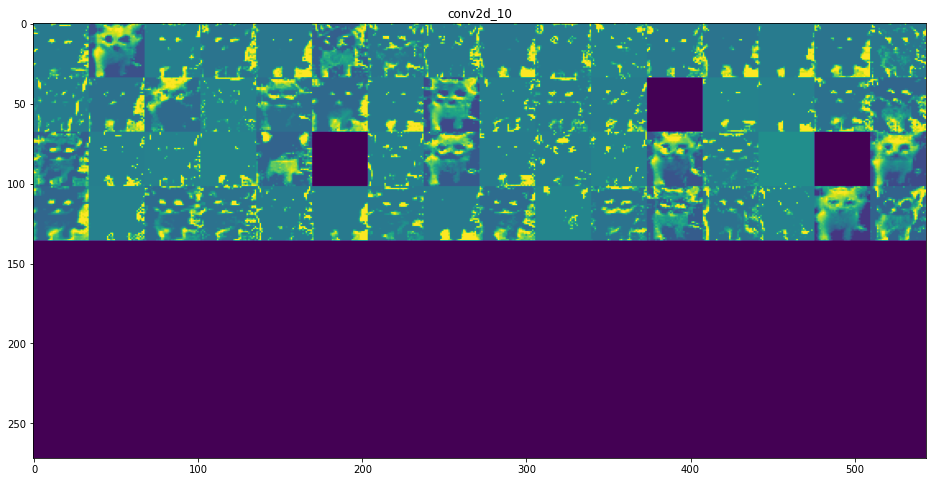

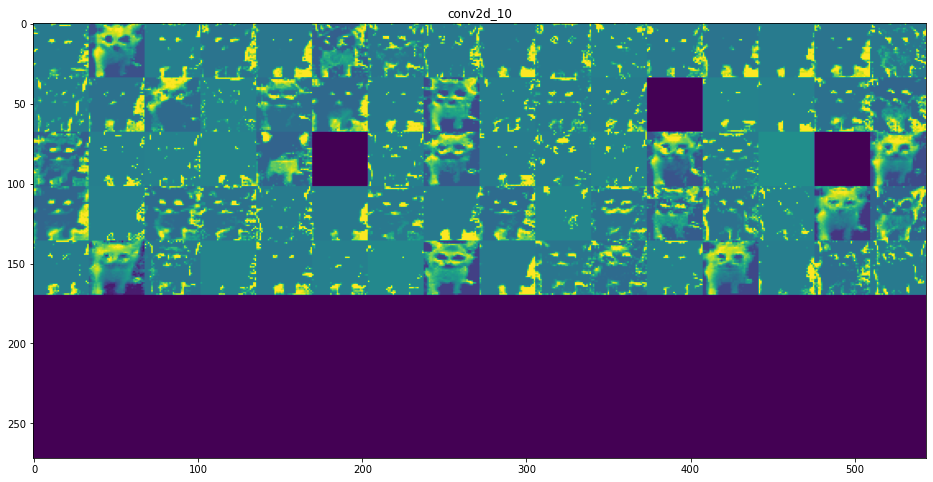

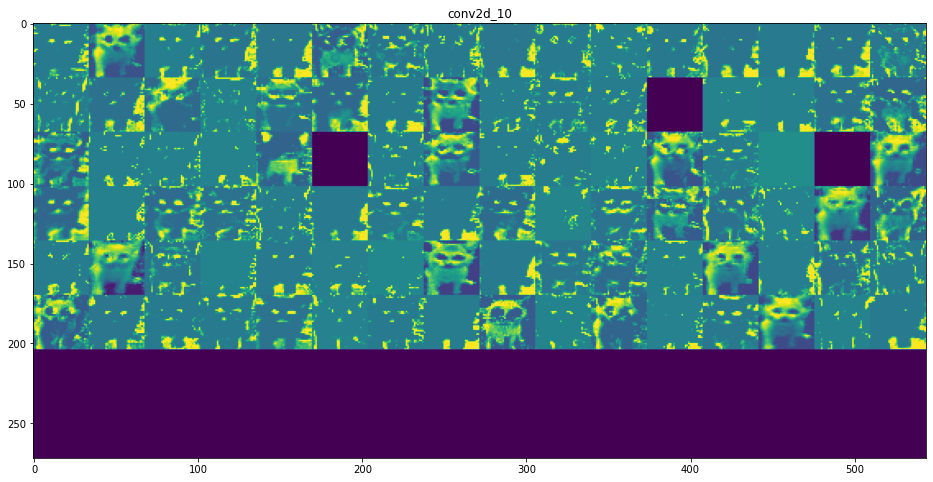

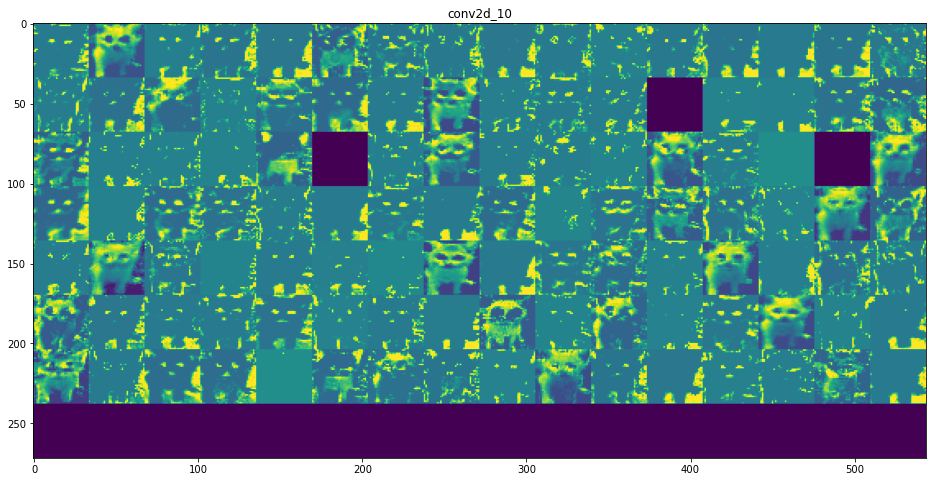

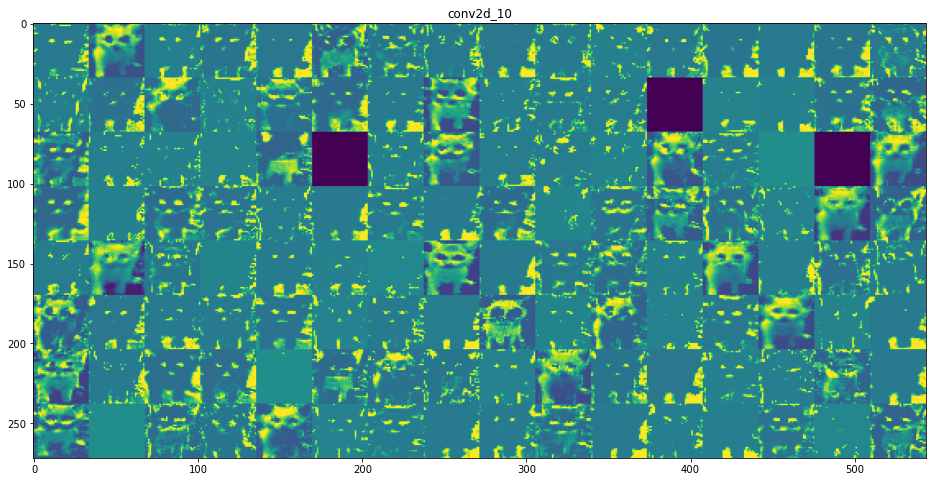

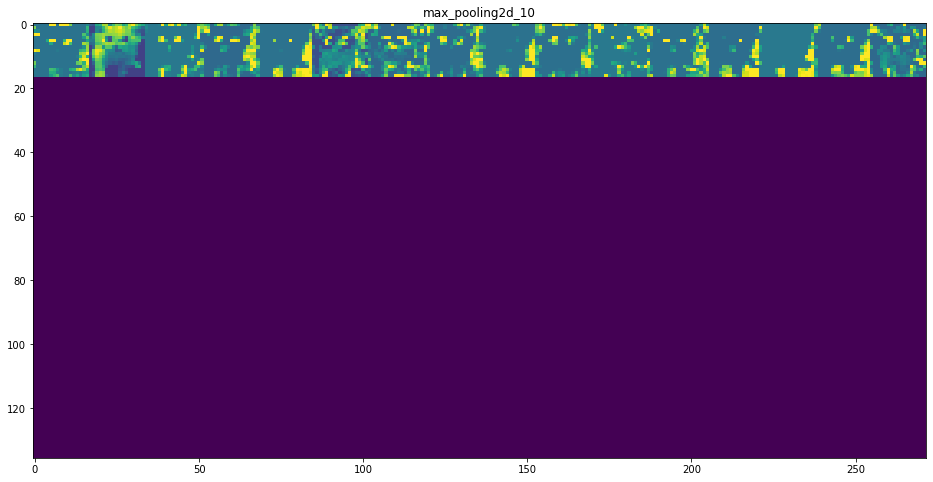

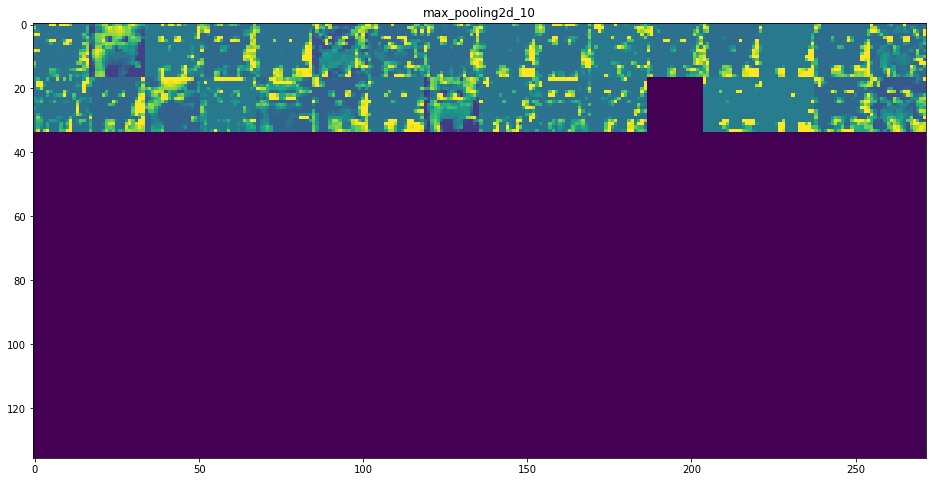

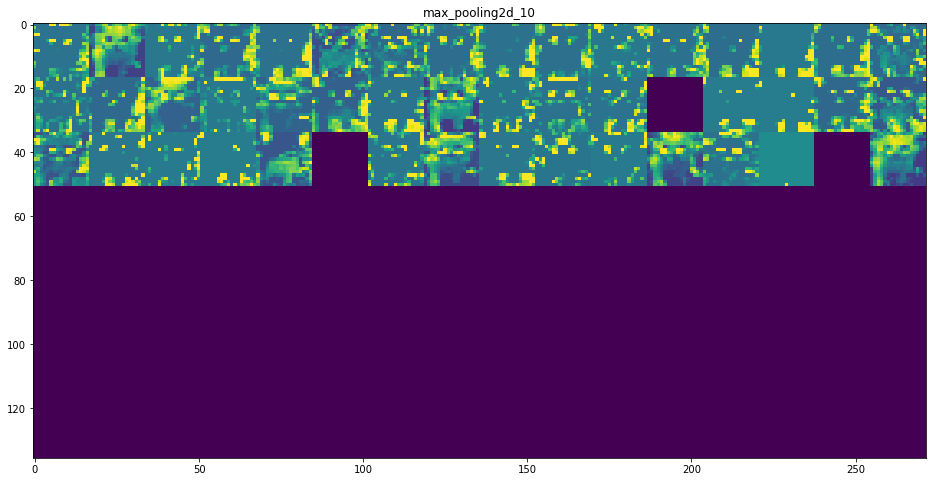

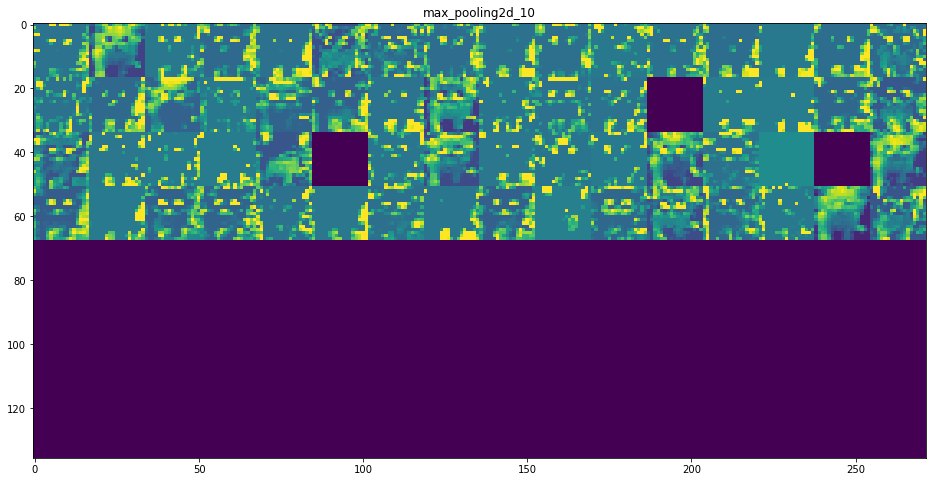

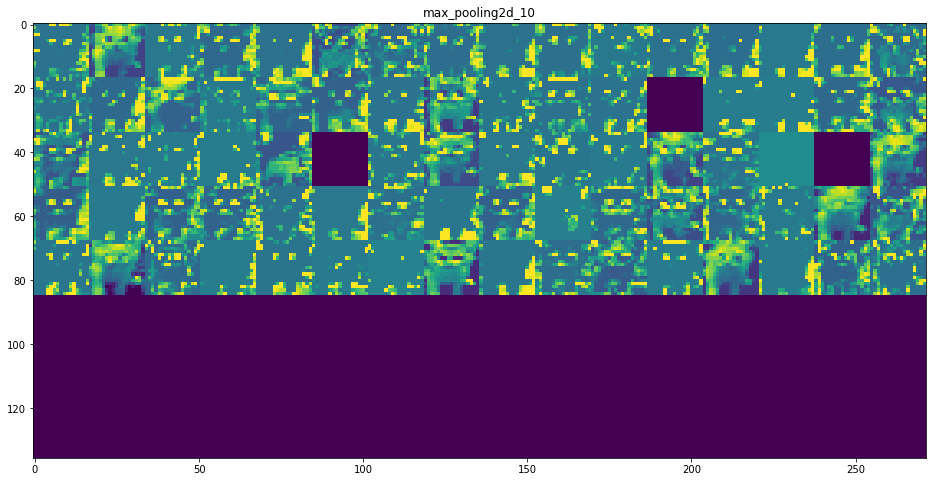

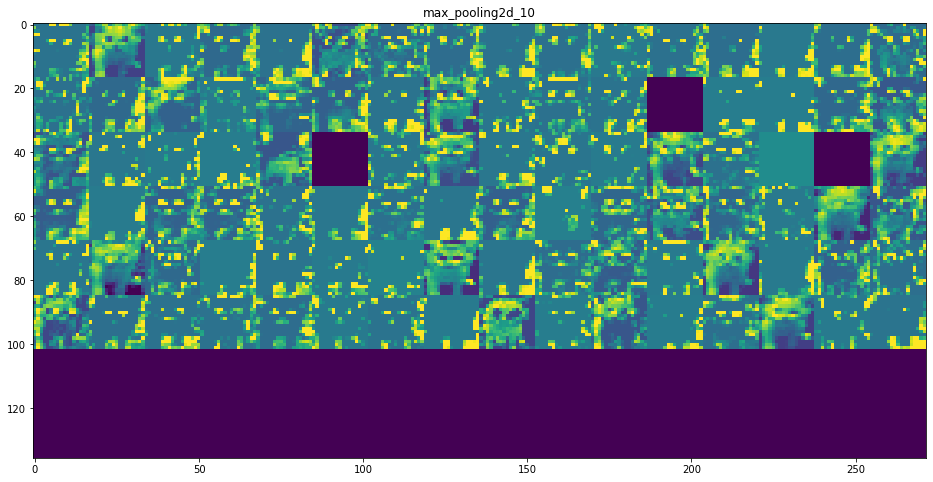

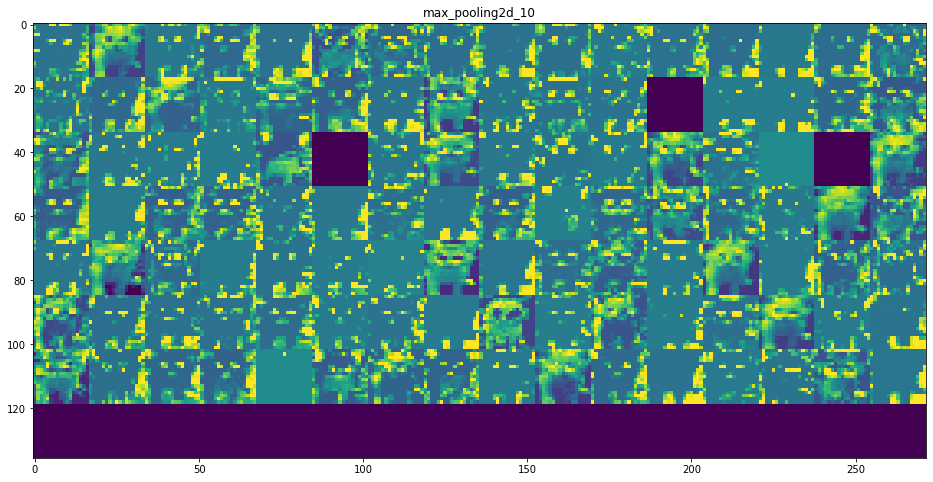

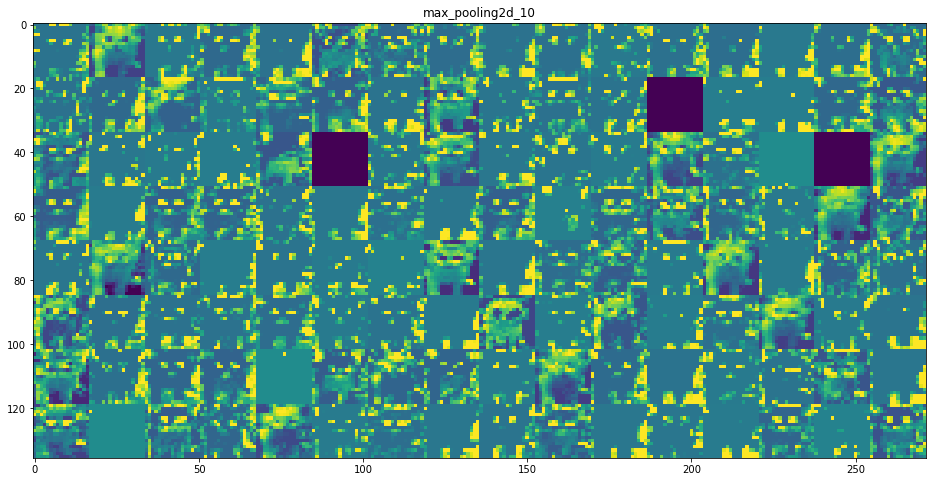

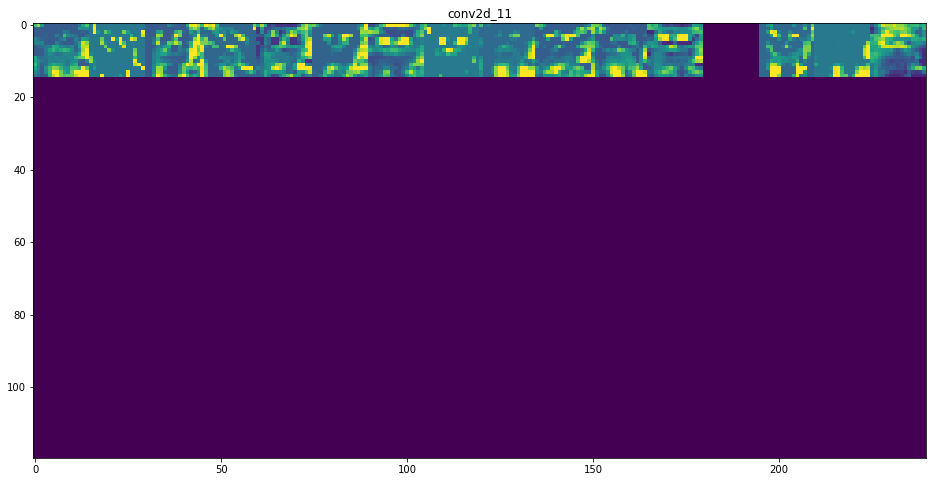

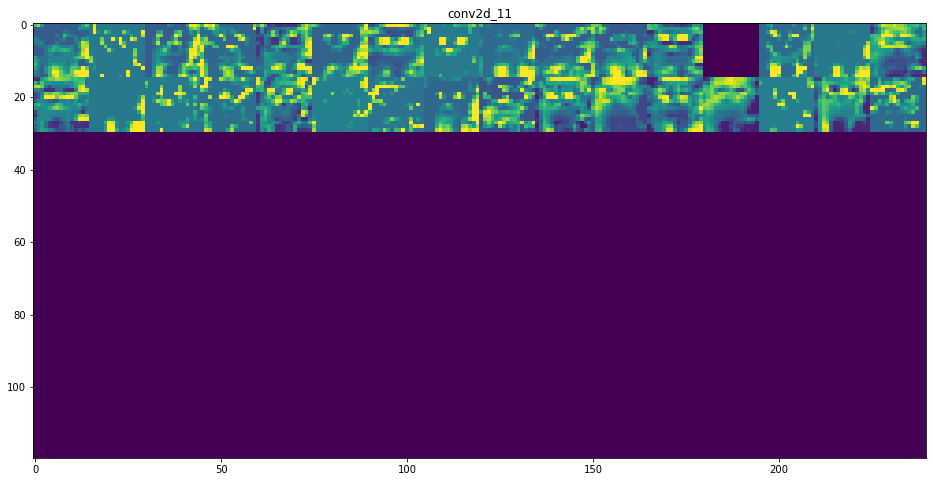

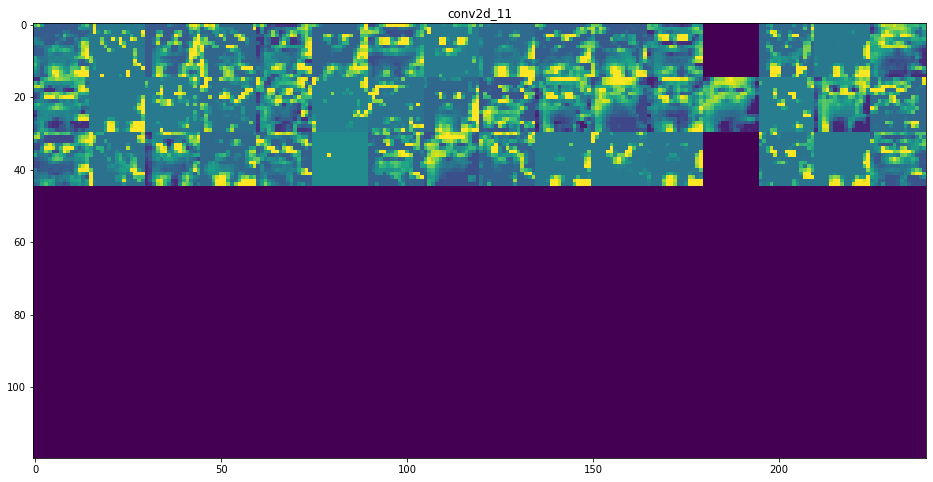

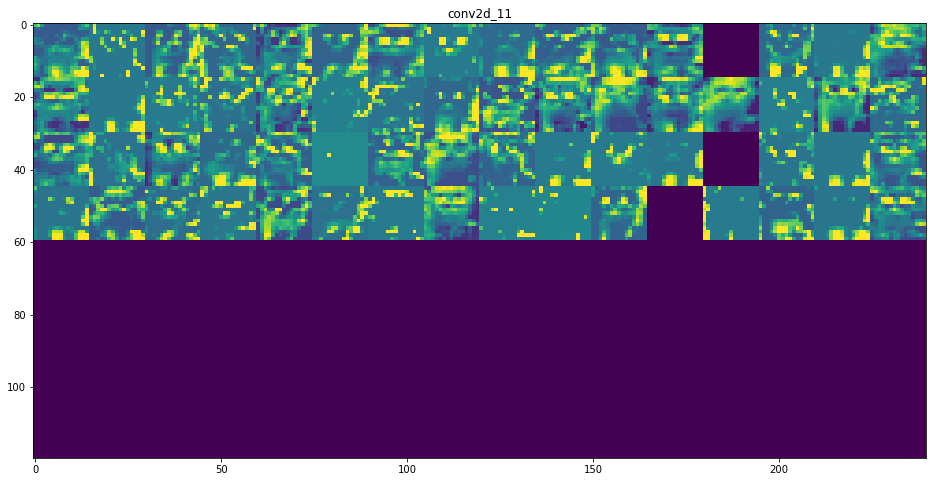

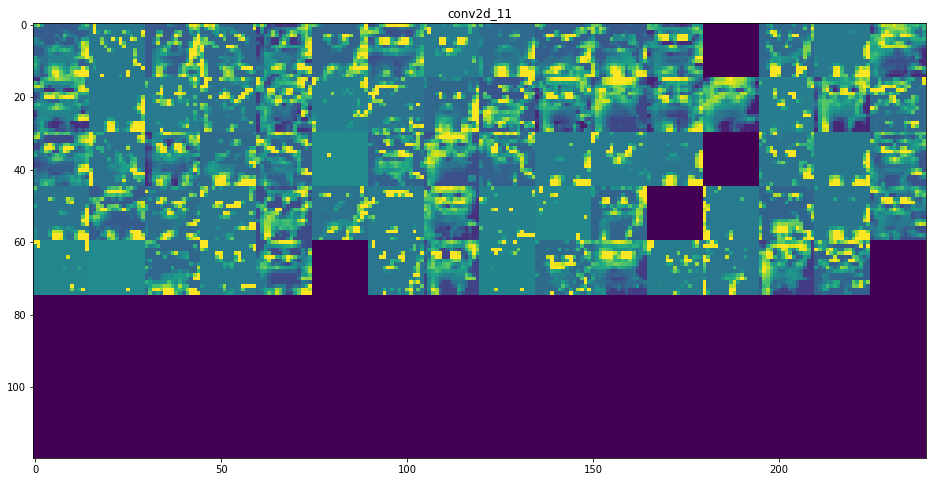

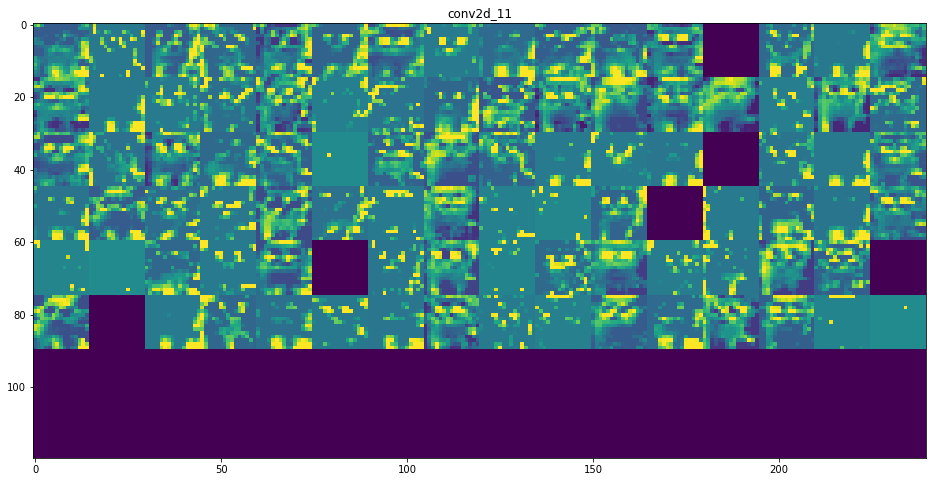

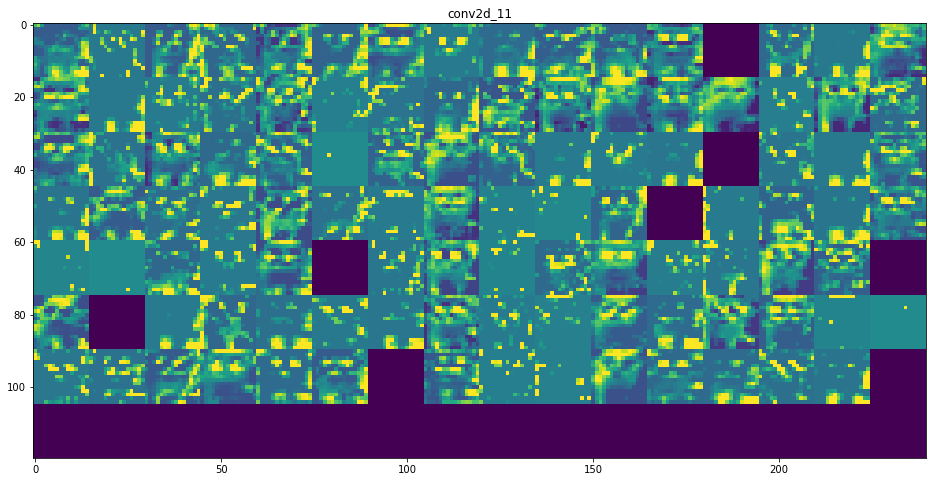

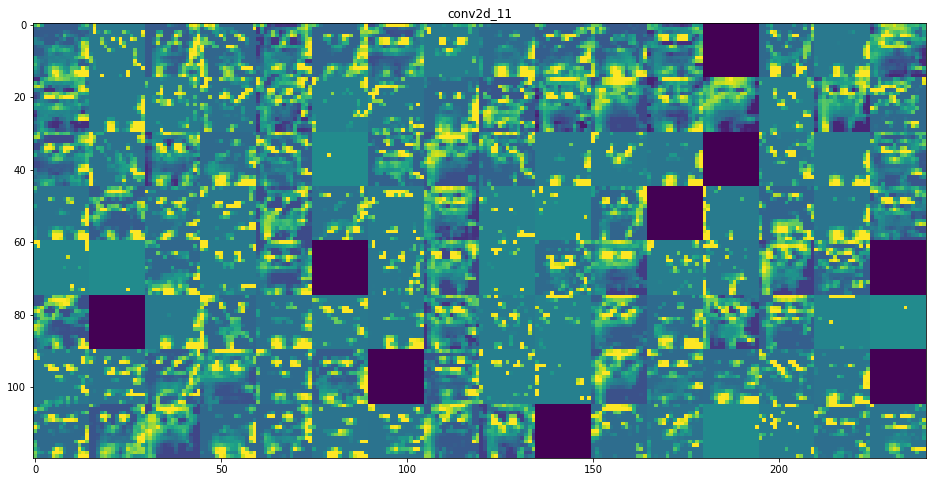

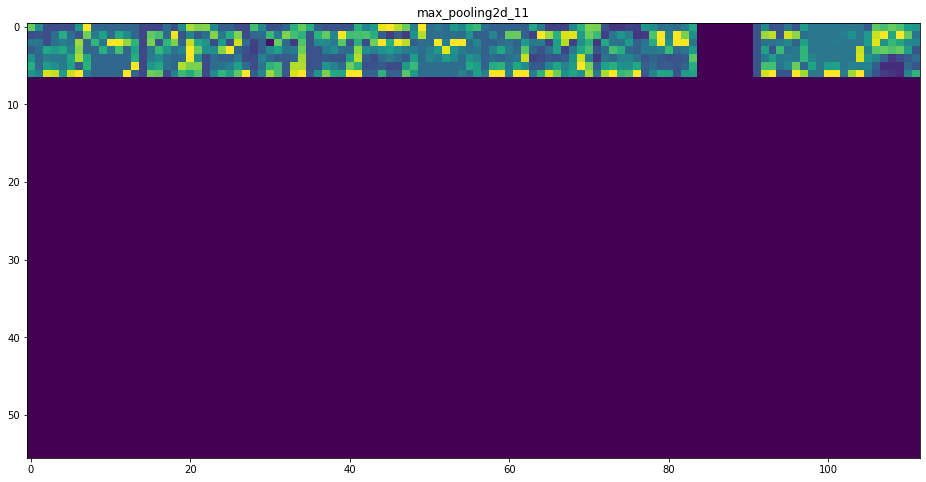

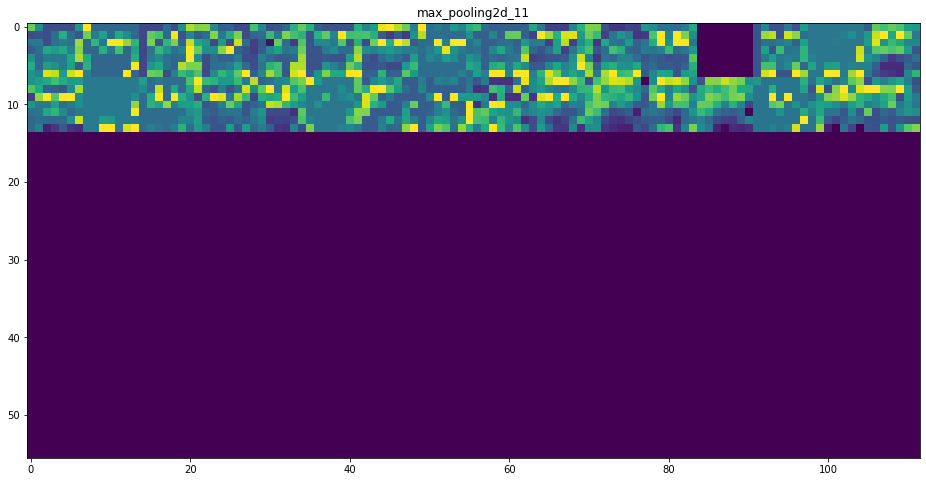

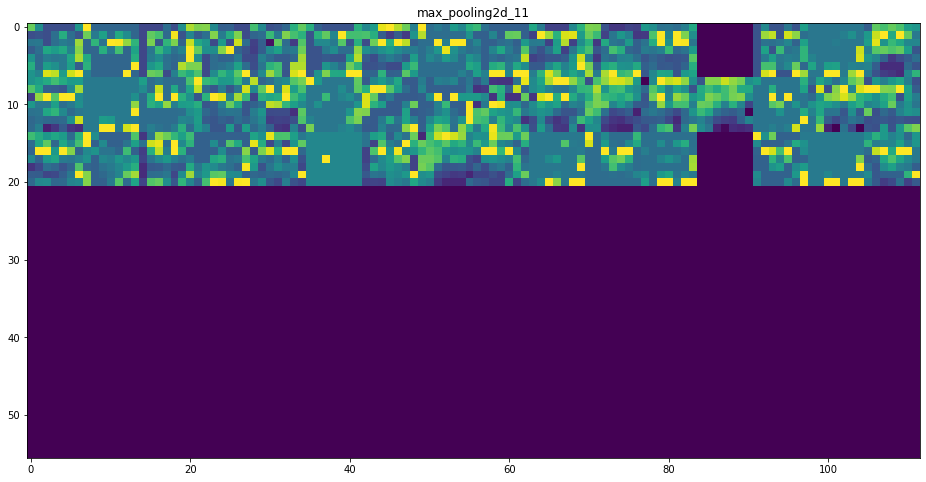

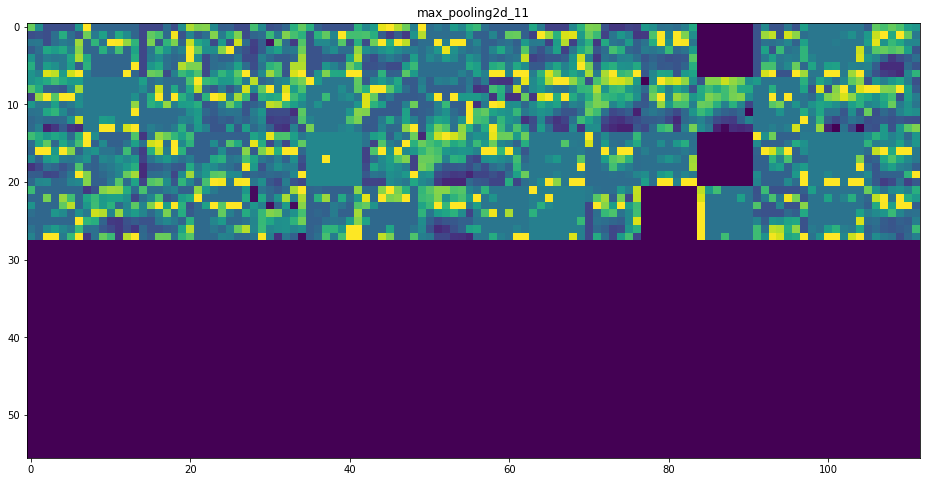

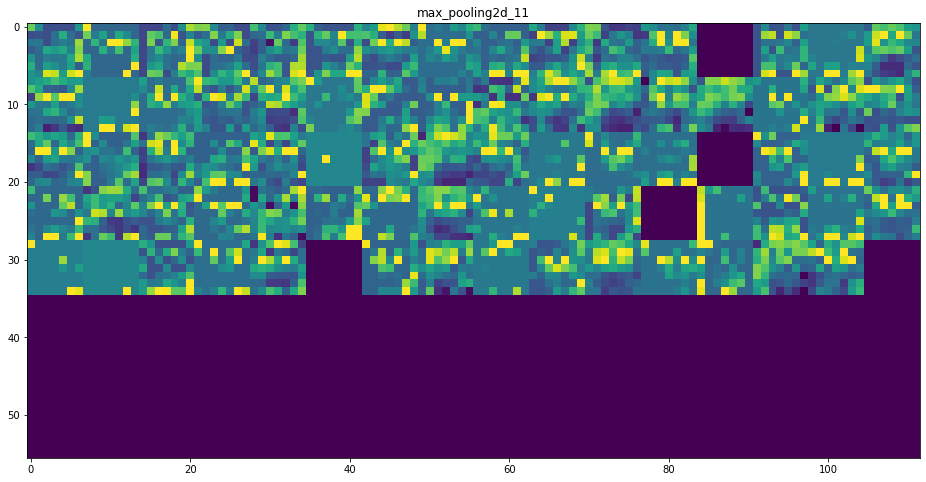

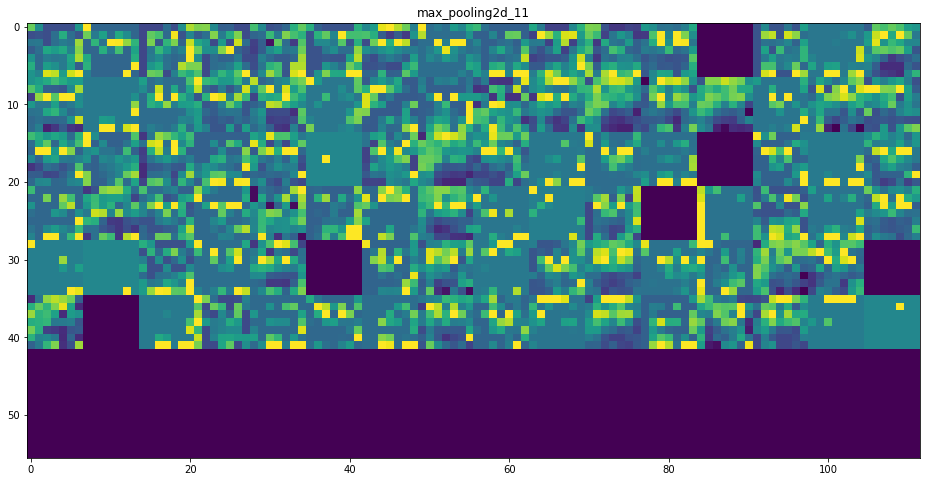

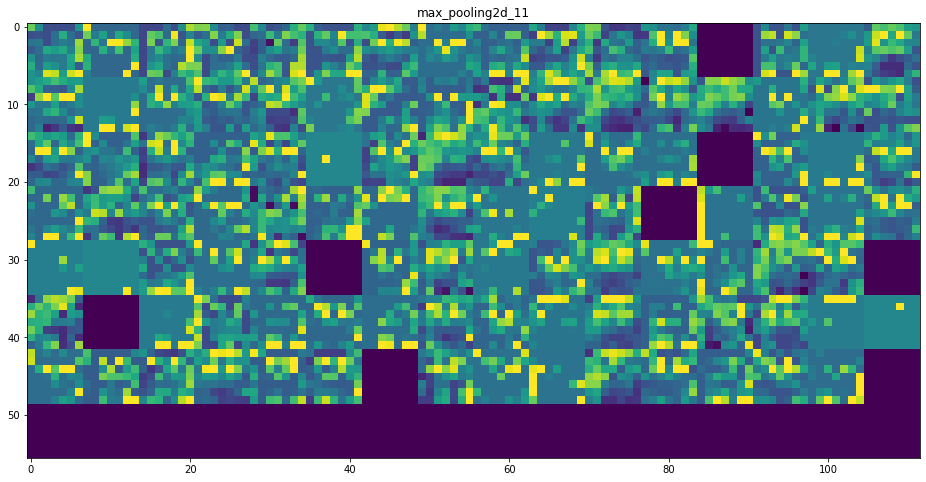

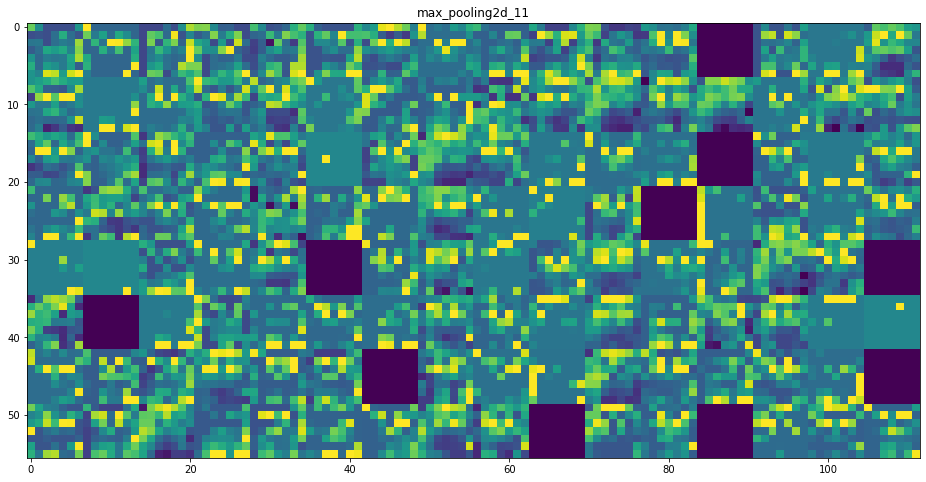

In [45]:
# 모든 층 시각화

layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
image_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):  # 특성 맵
    n_features = layer_activation.shape[-1]  # 특성 맵 당 특성 수
    
    size = layer_activation.shape[1]  # 특성 맵의 크기 = (1, size, size, n_features)
    
    n_cols = n_features // image_per_row  # 활성화 채널을 위한 그리드 크기
    display_grid = np.zeros((size * n_cols, image_per_row * size))
    
    for col in range(n_cols):
        for row in range(image_per_row):
            channel_image = layer_activation[0, :, :, col * image_per_row + row]
            
            # 그래프로 나타내기 좋게 처리
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col+1) * size, 
                         row * size : (row+1) * size] = channel_image
        
        scale = 1. / size
        
        plt.figure(figsize=(scale * display_grid.shape[1],
                           scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect="auto", cmap="viridis")
        
plt.show()

## 중간층 출력 시각화 결과

 * 하위 층은 이미지의 정보가 대부분 유지되며 주로 시각적 컨텐츠에 관한 정보가 인코딩됨
 
 
 * 상위 층으로 갈수록 활성화가 점점 더 추상적으로 변화함. 시각적 컨텐츠가 줄어들고 고양이 귀나 눈 등의 고수준의 클래스 정보가 인코딩됨
 
 
 * 상위 층으로 갈수록 비어 있는 활성화가 많아짐. 필터에 인코딩된 패턴이 이미지에 나타나지 않았다는 의미
  
  * 보다 상위 층으로 갈수록 종에 따른 특성 등 더욱 고수준 정보가 인코딩된듯함

In [14]:
# 2. 필터를 시각화
# 필터 활성화를 최대로 하기 위해 경사 상승법 사용

from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.enable_eager_execution()

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])


grads = K.gradients(loss, model.input)[0]  # gradients 함수가 반환하는 텐서 리스트에서 첫번째 텐서 추출

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  # 그래디언트 정규화(그래디언트 클리핑)

iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [5]:
import numpy as np

# 잡음이 섞인 회색 이미지로 시작
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.  # 업데이트할 그래디언트의 크기
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

NameError: name 'iterate' is not defined

In [ ]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
import matplotlib.pyplot as plt

def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

## 필터 시각화 결과

* tf 버전업으로 인한 에러가 발생하여 수정 필요

In [17]:
# 3. 클래스 활성화 히트맵 시각화

from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights="imagenet")

553467904/553467096 [==============================] - 59s 0us/step


In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path="datasets/creative_commons_elephant.jpg"

# 이미지 전처리
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)  # 채널별 컬러 정규화 실행

In [24]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354584)]


In [25]:
# 예측 벡터의 '아프리카 코끼리' 항목
african_elephant_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [26]:
import cv2

# cv2 모듈을 사용해 원본 이미지를 로드합니다
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경합니다
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다
cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

NameError: name 'heatmap' is not defined